In [691]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.interpolate import CubicSpline
from prophet import Prophet
import xgboost as xgb

plt.rcParams['figure.constrained_layout.use'] = True # 自动约束布局

In [692]:
df = pd.read_csv("data_preprocessed(特征未归一化).csv", parse_dates=[0])
df.sort_values(by='Date', inplace=True)

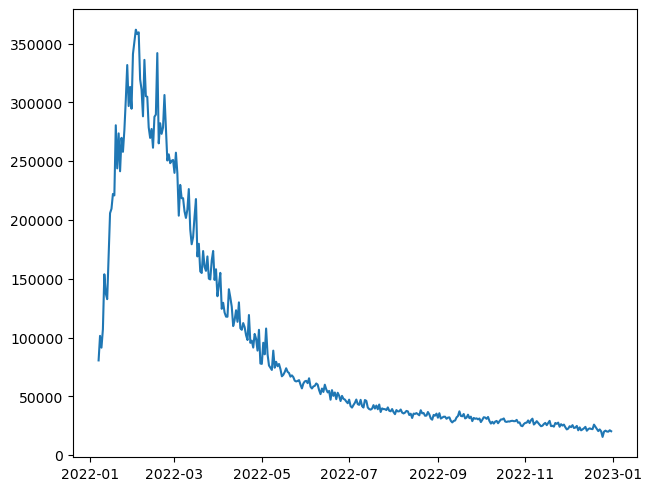

In [693]:
plt.plot(df['Date'], df['Number of  reported results'])

In [694]:
starttime = '2022-06'
endtime = '2023-03'

In [695]:
ts = df.loc[:,['Date', 'Number of  reported results']]
ts.columns = ['ds', 'y']
ts = ts[ts.ds >= starttime]
ts.reset_index(drop=True, inplace=True) # 重置索引
ts.head()

,ds,y
0,2022-06-01,63241
1,2022-06-02,61278
2,2022-06-03,65431
3,2022-06-04,58263
4,2022-06-05,56738


In [696]:
def func(x, a, b, c):
    return a*np.exp(-b*x) + c

popt, pcov = opt.curve_fit(func, xdata=ts.index, ydata=ts.y, bounds=(0, np.inf))
print("popt:", popt)
print("pocv:", pcov)

popt: [3.88995224e+04 1.30911060e-02 2.11967728e+04]
pocv: [[ 4.37808565e+05 -1.21130815e-01 -2.46428518e+05]
 [-1.21130815e-01  4.92466877e-07  4.42061838e-01]
 [-2.46428518e+05  4.42061838e-01  4.70322097e+05]]


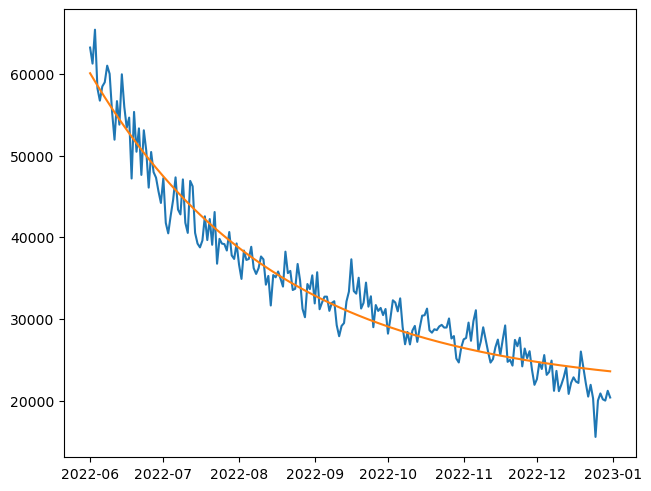

In [697]:
plt.plot(ts.ds, ts.y)
plt.plot(ts.ds, func(ts.index, *popt))

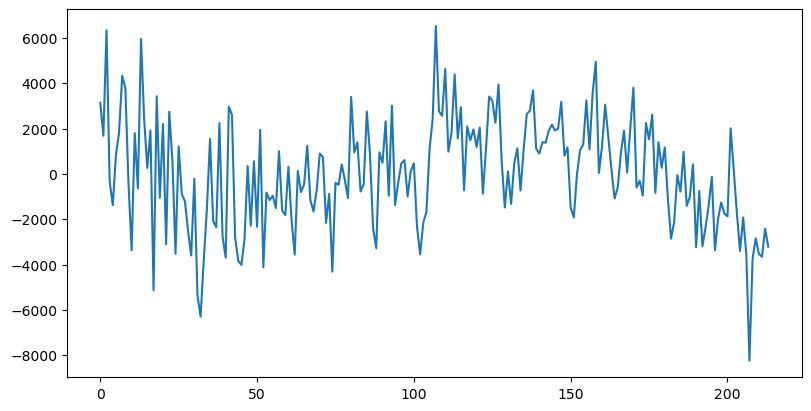

In [698]:
residual = ts.copy()
residual.y = ts.y - func(ts.index, *popt)
plt.figure(figsize=(8, 4))
plt.plot(residual.y)

In [699]:
m = Prophet(interval_width=0.95)
m.add_country_holidays(country_name='US')
m.fit(residual)

21:50:29 - cmdstanpy - INFO - Chain [1] start processing
21:50:29 - cmdstanpy - INFO - Chain [1] done processing


In [700]:
future = m.make_future_dataframe(periods=60)
future.tail()

,ds
269,2023-02-25
270,2023-02-26
271,2023-02-27
272,2023-02-28
273,2023-03-01


In [701]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
269,2023-02-25,-1303.173759,-5789.982336,3043.333142
270,2023-02-26,-933.678787,-5298.329482,3275.655063
271,2023-02-27,-238.955303,-5069.329138,4125.682447
272,2023-02-28,54.096801,-4454.425645,4312.215620
273,2023-03-01,213.219734,-4047.798691,4606.308512


d:\CodingEnv\mambaforge\envs\prophet\Lib\site-packages\prophet\plot.py:92: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


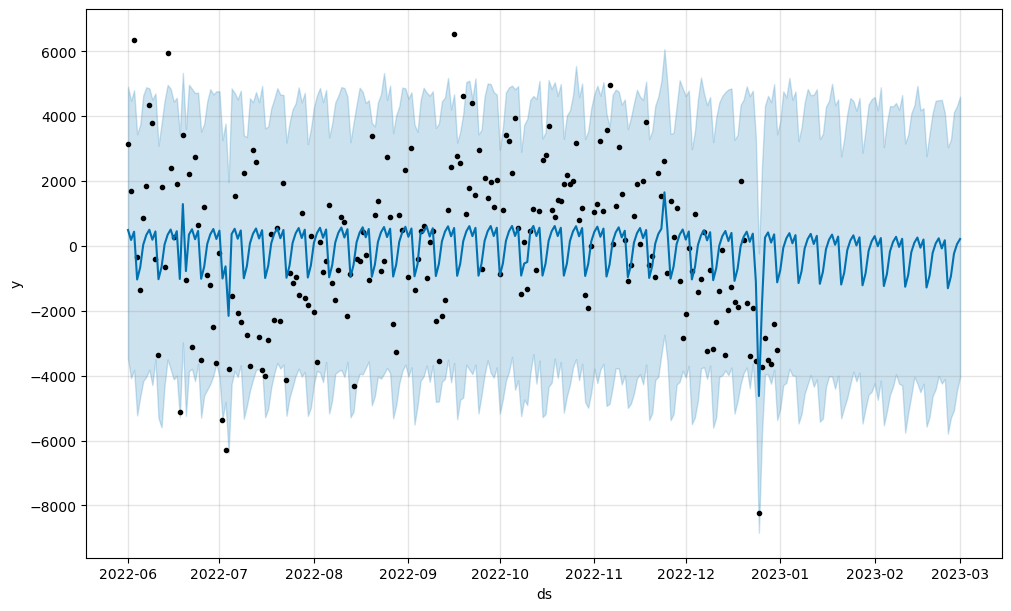

In [702]:
fig1 = m.plot(forecast)

In [703]:
# fig2 = m.plot_components(forecast)

In [704]:
y = func(future.index[-60:], *popt)
ylow = y + forecast.yhat_lower.iloc[-60:,].values
yupp = y + forecast.yhat_upper.iloc[-60:,].values

In [705]:
future.index

RangeIndex(start=0, stop=274, step=1)

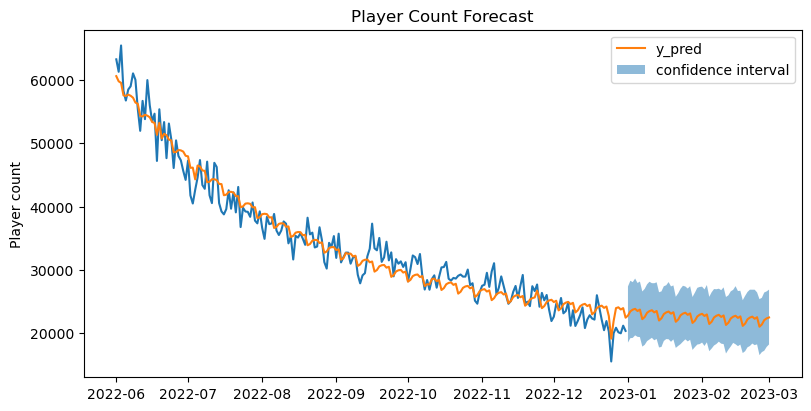

In [706]:
plt.figure(figsize=(8,4))
plt.plot(ts.ds, ts.y)
plt.plot(future.ds, func(future.index, *popt)+forecast.yhat, label='y_pred')
plt.fill_between(future.ds[-60:], ylow, yupp, alpha=0.5,
                label='confidence interval')
plt.ylabel('Player count')
plt.legend()
plt.title('Player Count Forecast')

# plt.savefig("Player Count Forecast.svg")
plt.show()

In [707]:
m_all = Prophet(interval_width=0.95)
m_all.add_country_holidays('US')
m_all.fit(ts)

21:50:30 - cmdstanpy - INFO - Chain [1] start processing
21:50:30 - cmdstanpy - INFO - Chain [1] done processing


In [708]:
forecast_all = m_all.predict(future)

d:\CodingEnv\mambaforge\envs\prophet\Lib\site-packages\prophet\plot.py:92: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


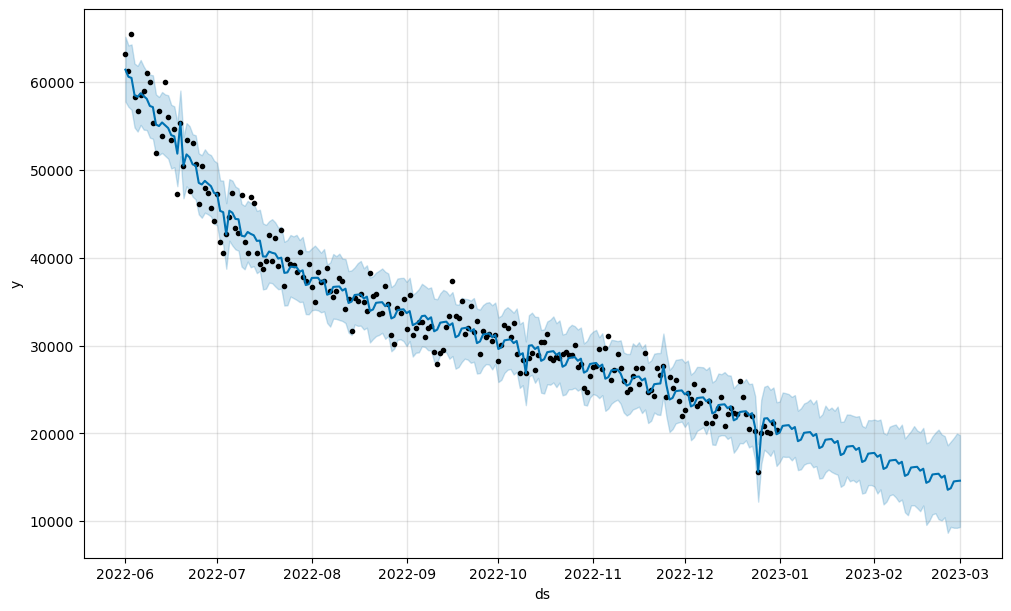

In [709]:
fig3 = m_all.plot(forecast_all)

In [710]:
data_uptodate = pd.read_csv('data_uptodate.csv', index_col=0, parse_dates=[0])

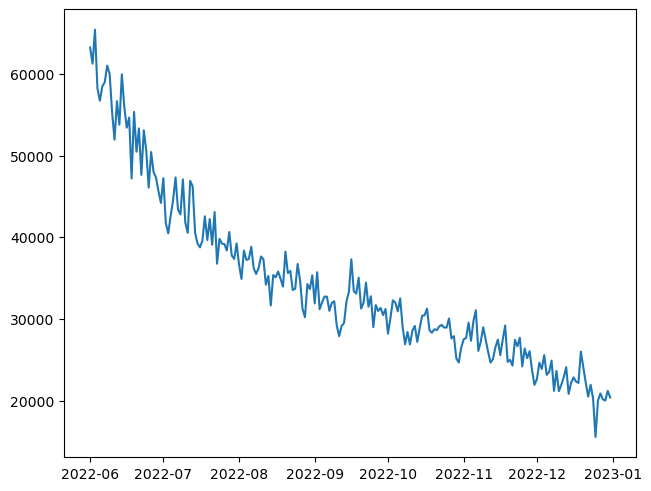

In [711]:
plt.plot(ts.ds, ts.y, label='Actual')

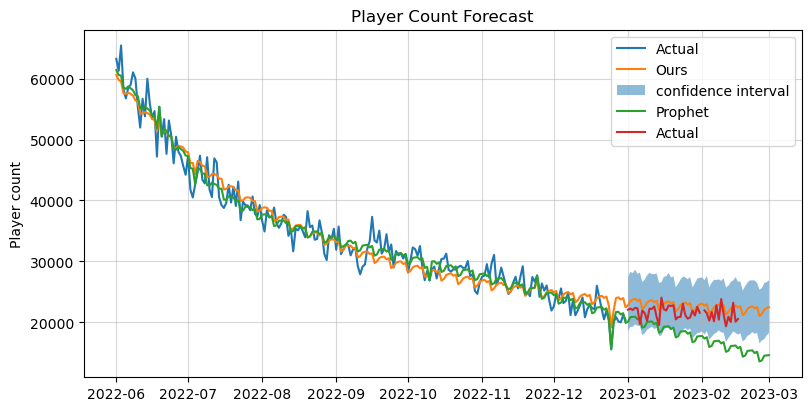

In [712]:
plt.figure(figsize=(8,4))

plt.plot(ts.ds, ts.y, label='Actual')
plt.plot(future.ds, func(future.index, *popt)+forecast.yhat, label='Ours')
plt.fill_between(future.ds[-60:], ylow, yupp, alpha=0.5,
                label='confidence interval')
plt.plot(future.ds, forecast_all.yhat, label='Prophet')
plt.plot(data_uptodate, label='Actual')

plt.grid(True, alpha=0.5)
plt.ylabel('Player count')
plt.legend()
plt.title('Player Count Forecast')

plt.show()

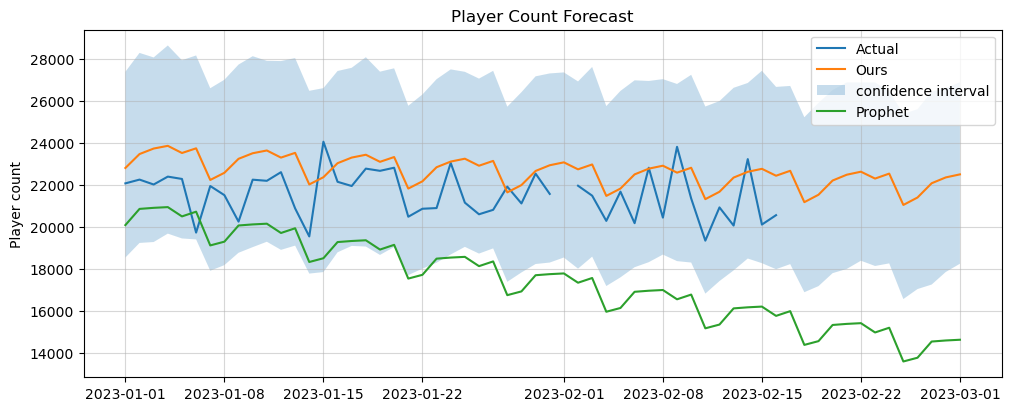

In [713]:
plt.figure(figsize=(10,4), layout='constrained')

plt.plot(data_uptodate, label='Actual')
plt.plot(future.ds[-60:], y+forecast.yhat[-60:],label='Ours')
plt.fill_between(future.ds[-60:], ylow, yupp, alpha=0.25,
                label='confidence interval')
plt.plot(future.ds[-60:], forecast_all.yhat[-60:], label='Prophet')

plt.grid(True, alpha=0.5)
plt.ylabel('Player count')
plt.legend()
plt.title('Player Count Forecast')

# plt.savefig('Forecast Contrast.svg')
plt.show()

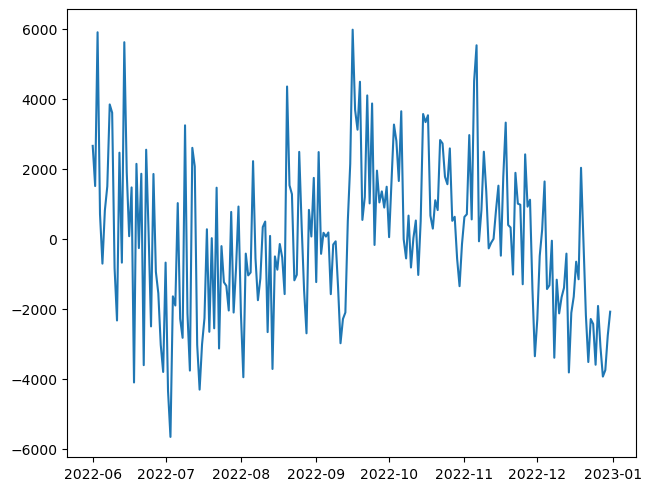

In [728]:
residual_train = ts.y.values - func(ts.index, *(popt)) - forecast.yhat[:ts.shape[0]]
plt.plot(ts.ds, residual_train)

[0]	validation_0-rmse:2126.55880
[1]	validation_0-rmse:2051.15159
[2]	validation_0-rmse:1982.34576
[3]	validation_0-rmse:1921.09676
[4]	validation_0-rmse:1866.96753
[5]	validation_0-rmse:1813.43709
[6]	validation_0-rmse:1766.73440
[7]	validation_0-rmse:1718.86917
[8]	validation_0-rmse:1678.11516
[9]	validation_0-rmse:1651.04247
[10]	validation_0-rmse:1620.61936
[11]	validation_0-rmse:1582.82626
[12]	validation_0-rmse:1556.45414
[13]	validation_0-rmse:1529.62936
[14]	validation_0-rmse:1502.50966
[15]	validation_0-rmse:1485.15447
[16]	validation_0-rmse:1466.96916
[17]	validation_0-rmse:1445.16094
[18]	validation_0-rmse:1434.26218
[19]	validation_0-rmse:1414.83224
[20]	validation_0-rmse:1401.85873
[21]	validation_0-rmse:1391.24463
[22]	validation_0-rmse:1373.35429
[23]	validation_0-rmse:1359.23438
[24]	validation_0-rmse:1349.87090
[25]	validation_0-rmse:1333.43821
[26]	validation_0-rmse:1321.82063
[27]	validation_0-rmse:1309.01011
[28]	validation_0-rmse:1298.64786
[29]	validation_0-rmse:1

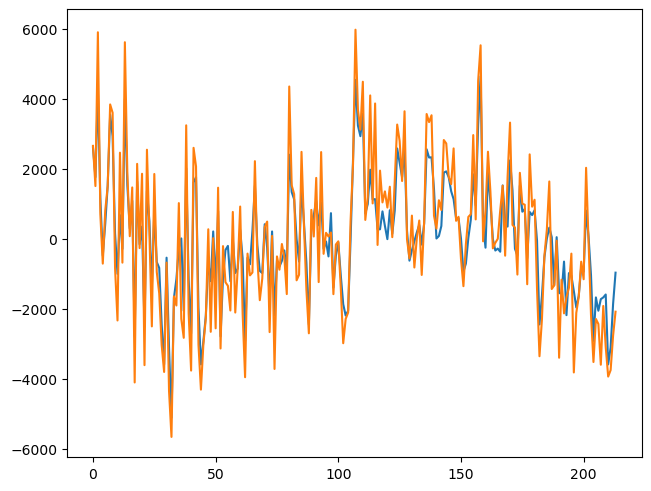

In [740]:
model_X = xgb.XGBRegressor(n_estimators=100,
                        eta=0.1,
                        max_depth=6,
                        # colsample_bytree=0.6,
                        random_state=0,
                        early_stopping_rounds=50
                        )

model_X.fit(X=residual_train.shift(1).values.reshape(-1,1), y=residual_train.values,
        eval_set=[(residual_train.shift(1).values.reshape(-1,1), residual_train.values)],
        verbose=True) # Change verbose to True if you want to see it residual
forecast_X = model_X.predict(residual_train.shift(1).values.reshape(-1,1))

plt.plot(forecast_X)
plt.plot(residual_train)

In [742]:
# res_pred = [train.values[-1][0]]
res_x= [ts.y.values[-1]]
res_y = []

for i in range(60):
    new_res = model_X.predict(np.array(res_x[-1]).reshape(1,-1))[0]
    res_y.append(new_res)
    res_x.append(new_res)

residual_pred = res_y

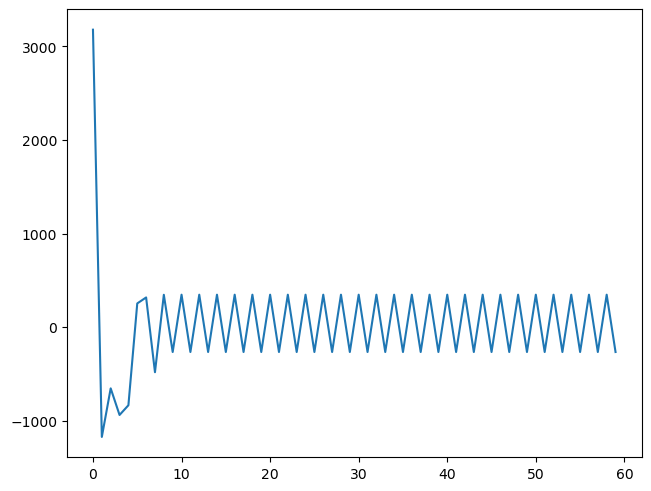

In [743]:
plt.plot(residual_pred)

In [753]:
y = func(future.index[-60:], *popt)
ylow = y + forecast.yhat_lower.iloc[-60:,].values + residual_pred
yupp = y + forecast.yhat_upper.iloc[-60:,].values + residual_pred

In [769]:
pred_all = pd.concat([func(ts.index, *popt)+forecast.yhat[:ts.shape[0]]+forecast_X, func(forecast.index[-60:], *popt)+forecast.yhat[-60:]+residual_pred])

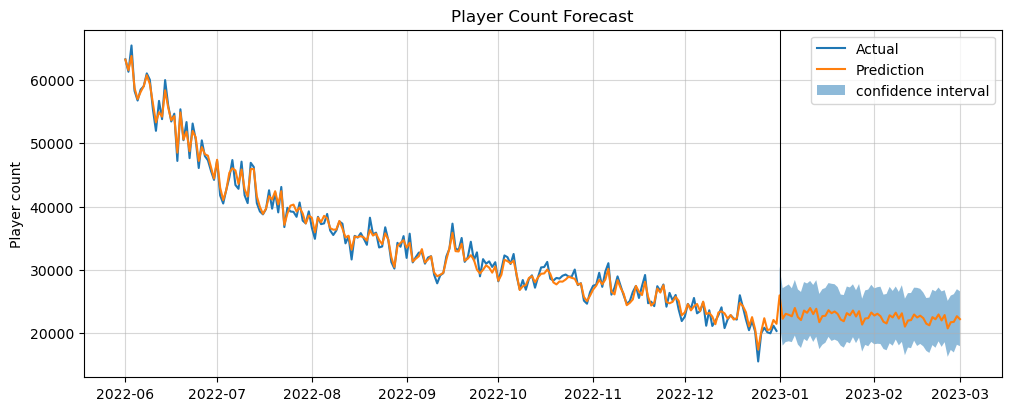

In [789]:
plt.figure(figsize=(10,4))
plt.plot(ts.ds, ts.y, label='Actual')
# plt.plot(ts.ds, func(ts.index, *popt)+forecast.yhat[:ts.shape[0]]+forecast_X, label='y_pred')
# plt.plot(future.ds[-60:], func(forecast.index[-60:], *popt)+forecast.yhat[-60:]+residual_pred)
plt.plot(future.ds, pred_all, label='Prediction')
plt.fill_between(future.ds[-60:], ylow, yupp, alpha=0.5,
                label='confidence interval')

plt.axvline(x=pd.to_datetime('2023-01-01'), c='k', linewidth=0.75)
plt.grid(True, alpha=0.5)
plt.ylabel('Player count')
plt.legend()
plt.title('Player Count Forecast')

# plt.savefig("Player Count Forecast.svg")
plt.show()

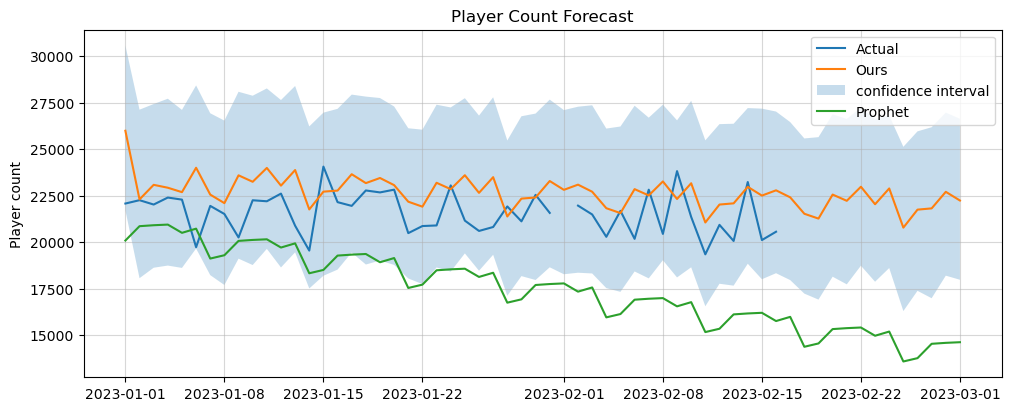

In [756]:
plt.figure(figsize=(10,4), layout='constrained')

plt.plot(data_uptodate, label='Actual')
plt.plot(future.ds[-60:], y+forecast.yhat[-60:]+residual_pred,label='Ours')
plt.fill_between(future.ds[-60:], ylow, yupp, alpha=0.25,
                label='confidence interval')
plt.plot(future.ds[-60:], forecast_all.yhat[-60:], label='Prophet')

plt.grid(True, alpha=0.5)
plt.ylabel('Player count')
plt.legend()
plt.title('Player Count Forecast')

# plt.savefig('Forecast Contrast.svg')
plt.show()

In [758]:
y

Float64Index([  23558.7174127366,  23527.99845624494, 23497.679024057084,
               23467.75392004375,  23438.21801565542, 23409.066249043422,
              23380.293624192425,  23351.89521006422, 23323.866139752652,
               23296.20160964952, 23268.896878621348,  23241.94726719685,
               23215.34815676496, 23189.094988783294, 23163.183263996918,
               23137.60854166726, 23112.366438811074,  23087.45262944926,
              23062.862843865503,  23038.59286787452,  23014.63854209983,
               22990.99576126095,   22967.6604734698, 22944.628679536305,
              22921.896432283018,  22899.45983586866, 22877.315045120442,
              22855.458264875084, 22833.885749328405, 22812.593801393374,
               22791.57877206649, 22770.837059802423, 22750.365109896797,
              22730.159413876965, 22710.216508900754, 22690.532977162966,
              22671.105445309684, 22651.930583860114, 22633.005106635985,
              22614.325770198386, 2259

In [759]:
ylow

Float64Index([21713.754232214298, 18057.924643253056, 18620.634063856865,
              18736.501363001116,  18610.22528688896,  19652.62765399841,
              18222.313280310176, 17691.709491992864, 19108.275464434893,
               18765.08363649396,  19634.64199344475, 18635.532938533885,
              19449.695192915533, 17504.470288201188,  18188.19201805661,
               18519.23490922179, 19436.470284979496,  18793.94977849539,
              19007.064948024952, 18772.097969057522,  18043.83306479893,
              17740.118212123918, 18634.616248019982,  18415.56702667845,
                 19390.690898514,  18458.10450681448,  19317.30767692874,
              17112.343213718457, 18169.991693735214, 17960.434442374517,
              18643.279319297442,  18270.48281043431,  18351.87398969931,
                18312.2151369262, 17523.659833537098, 17324.325278797085,
              18420.382453013095, 18047.608356261124, 19022.496681809185,
               18098.86988196158,  186

In [760]:
yupp

Float64Index([ 30571.16494530959, 27118.700551831425, 27421.662210211332,
              27707.561475435177, 27107.713618657413,  28423.90943930784,
               26925.34681721243, 26531.279726713525,  28081.16974528606,
              27869.378687759294,  28261.31508903986, 27637.433873332477,
               28392.39717412177,  26219.10998782452, 26959.137381175507,
              27163.712246487506, 27929.458134694425, 27822.058849645713,
              27745.070357635825,  27291.24436451638,  26119.25878045789,
              26043.622783607378, 27385.418870883375, 27239.632225732967,
               27737.56315171421, 26801.309115364555, 27783.995078989148,
              25463.063033222505, 26765.251586872506, 26909.158438521947,
               27660.55328641771,  27096.19289900821, 27278.595545599484,
               27355.48534712835, 26102.821759094382, 26213.741336315932,
              27331.113743105445,  26688.68556814021, 27387.335819934808,
              26546.084802341655,  275